---
title: Playing Battleship with Bayesian Search Theory, Thompson Sampling, and Approximate Bayesian Computation
tags: Battleship, Search Theory, Thompson Sampling, Approximate Bayesian Computation, Bayesian Statistics
---

As a child, I spent many hours playing [Battleship](https://en.wikipedia.org/wiki/Battleship_(game)) against my Mom or brother to pass the time.

<center><img src="https://s3.us-east-2.amazonaws.com/boardashell/battleship.jpeg" width=500></center>

Battleship is a classic game of [incomplete information](https://en.wikipedia.org/wiki/Complete_information) that involves placing ships of different lengths on a square grid ($10 \times 10$ in the most popular version) and trying to guess the location of all of the opponent's ships (sinking them) before the opponent does the same.

Many years after I stopped playing Battleship with my family, I developed an interest in [Bayesian search theory](https://en.wikipedia.org/wiki/Bayesian_search_theory) after learning about a firm that specializes in search consulting for the US government at jobs-in-industry panel in graduate school. I had already happily lined up a [job](https://kibocommerce.com/personalization-software/) in e-commerce optimization, but the idea of using statistics to guide the potentially expensive searches piqued my intellectual curiosity.  I e-mailed the presenter afterward for more information and he recommended [_Theory of Optimal Search_]^(Stone, Lawrence D. _Theory of optimal search._ Elsevier, 1976.) as the sessential reference in the field.  The book is interesting if a bit dry, it is about mathematical optimization after all, and I was always curious about the connection with the search theory it develops and Battleship, which has always stood out in my mind as a basic search problem.  Though most of the theory in this book is not directly applicable to Battleship for various reasons, a continuing theme is allocating search in areas with the largest posterior probability of containing the target object given the search results so far.  A 1985 result of [Assaf and Zamir]^(Assaf, David, and Shmuel Zamir. "Optimal sequential search: a Bayesian approach." _The Annals of Statistics_ 13, no. 3 (1985): 1213-1221.) shows the optimality of this strategy in a situation much closer to that of Battleship.

Inspired by these forays into search theory I have thought idly for many years about constructing a near-optimal Bayesian approach to playing Battleship.  This post is the culmination of these thoughts, showing how to use ideas from Bayesian search theory, [approximate Bayesian computation](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation) (ABC), and [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling) to construct an easily tractable, near optimal strategy for Battleship that only requires simulating random Battleship boards and not reasoning through hard-coded special cases to achieve strong play.

## Playing Battleship

First we make the necessary Python imports and do a bit of housekeeping.

In [1]:
%matplotlib inline

In [2]:
from abc import ABC, abstractmethod
import datetime
from IPython.display import HTML
from itertools import product
import multiprocessing as mp
from tqdm import tqdm, trange

In [3]:
from empiricaldist import Pmf
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import IndexLocator, StrMethodFormatter
import numpy as np
from scipy import linalg, stats
import seaborn as sns

In [4]:
FIG_WIDTH = 8
FIG_HEIGHT = 6
mpl.rcParams['figure.figsize'] = (FIG_WIDTH, FIG_HEIGHT)

CMAP = LinearSegmentedColormap.from_list(
    'battleship',
    [
        (0.0, 'blue'),
        (0.2, 'orange'),
        (1., 'red')
    ]
)
CMAP.set_bad('w')

sns.set(color_codes=True)

pct_formatter = StrMethodFormatter('{x:.1%}')

In [5]:
SEED = 123456789 # for reproducibility

rng = np.random.default_rng(SEED)

We represent a Battleship board as a sequence of rectangular grids, one per ship.  For standard Battleship, that means a game consists of five $10 \times 10$ grids, the first grid containing a ship of length five, the seconding containing a ship of length four, and so on.

The following constants are useful for defining a standard game of Battleship.  (Note that we are using Hasbro's [names](https://en.wikipedia.org/wiki/Battleship_(game)#Description) for the ships, revised in 2002.)

In [6]:
GRID_LENGTH = 10
SHIP_NAMES = [
    "Carrier",
    "Battleship",
    "Destroyer",
    "Submarine",
    "Patrol boat"
]
SHIP_SIZES = np.array([
    5, 
    4,
    3,
    3,
    2
])

n_ships = SHIP_SIZES.size

The following plots show how a Battleship board is represented as a sequence of five grids, one per ship.

In [7]:
ships = np.zeros((n_ships, GRID_LENGTH, GRID_LENGTH))
ships[0, 0, :5] = 1
ships[1, 4:8, 7] = 1
ships[2, 9, 3:6] = 1
ships[3, 3:6, 1] = 1
ships[4, 5, 8:10] = 1

In [8]:
def plot_board(board, cmap=CMAP,
               cbar=False, cbar_kwargs=None,
               ax=None, **heatmap_kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
        
    heatmap_kwargs.setdefault('vmin', 0)
    heatmap_kwargs.setdefault('vmax', 1)
    
    board_ = np.atleast_2d(board)
    mask = board_.mask if np.ma.is_masked(board_) else None
    
    if cbar_kwargs is None:
        cbar_kwargs = {}
        
    cbar_kwargs.setdefault('format', pct_formatter)
    cbar_kwargs.setdefault('label', "Posterior probability of a hit")
    
    sns.heatmap(board_, mask=mask, cmap=cmap,
                cbar=cbar, square=True,
                linewidths=1.5, linecolor='k',
                cbar_kws=cbar_kwargs,
                ax=ax, **heatmap_kwargs)
    
    if board_.shape[0] == 1:
        ax.set_yticklabels([])
        
    if cbar:
        cbar = ax.figure.axes[-1]
        cbar.set_ylabel(cbar.get_ylabel(), rotation=270)
        
    return ax

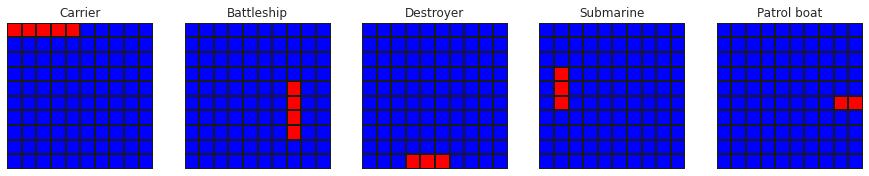

In [9]:
fig, axes = plt.subplots(ncols=n_ships, sharex=True, sharey=True,
                         figsize=(n_ships * 2.5, 2.5))

for (ship, name, ax) in zip(ships, SHIP_NAMES, axes):
    plot_board(ship, ax=ax);
    
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    ax.set_title(name);
    
fig.tight_layout();

Adding these ship grids gives us the two-dimensional board familiar to anyone who has played battleship.

In [10]:
def to_board(ships, ship_axis=0):
    return ships.sum(axis=ship_axis)

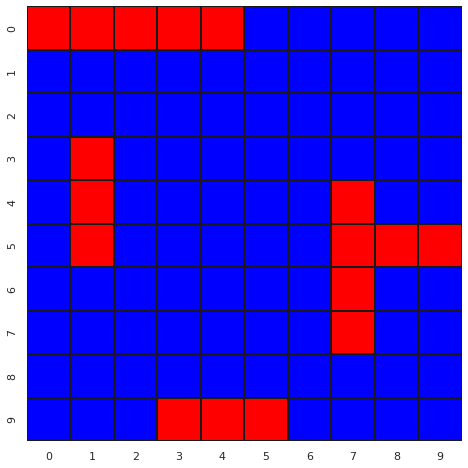

In [11]:
plot_board(to_board(ships));

The following class implements most of the basics necessary to track the state of a game of Battleship, make guesses, and reveal the contents of guessed spaces.

In [12]:
class Battleship:
    def __init__(self, ships):
        self._ships = ships
        self._turn_revealed = []
        
    @property
    def _board(self):
        return to_board(self._ships)
        
    @property
    def grid_length(self):
        return self._board.shape[0]
    
    @property
    def is_solved(self):
        return self.revealed.sum() == self._board.sum()
    
    @property
    def revealed(self):
        return to_board(self._revealed_ships)
        
    @property
    def _revealed_ships(self):
        if self.turns > 0:
            return self._turn_revealed[-1]
        else:
            return np.ma.masked_all_like(self._ships)
    
    @property
    def ship_sizes(self):
        return self._ships.sum(axis=(1, 2))
    
    @property
    def sunk(self):
        ship_sizes = self._ships.sum(axis=(1, 2))
        revealed_sizes = (self._revealed_ships
                              .sum(axis=(1, 2))
                              .filled(0))
        
        return ship_sizes == revealed_sizes
    
    @property
    def turn_revealed(self):
        return [np.ma.masked_all_like(self._board)] \
                + [to_board(revealed) for revealed in self._turn_revealed]
    
    @property
    def turns(self):
        return len(self._turn_revealed)

These bookkeeping methods are fairly self-explanatory.  An instance of `Battleship` tracks which squares have been revealed to the opponent using `numpy`'s [masked arrays](https://numpy.org/doc/stable/reference/maskedarray.generic.html).  The `revealed` grid is masked wherever the opponent has not yet guessed.

The heart of our `Battleship` class is the `guess` method, which takes the coordinates to guess, and returns a tuple containing whether or not the guess resulted in a hit or miss, and the index of the ship sunk as a result of that guess (`None` if no ship was sunk).  (Here we use a [dirty trick](https://www.cgranade.com/blog/2016/10/07/documenting-long-classes-jupyter-notebook.html) to add a method to the `Battleship` class after it has already been defined for expository clarity. **Don't do this in practice!**)

In [13]:
class Battleship(Battleship):
    def guess(self, i, j):
        if not self.revealed.mask[i, j]:
            raise ValueError(f"{i}, {j} already guessed")
        else:
            prev_sunk = self.sunk

            next_ships = self._revealed_ships.copy()
            next_ships[:, i, j] = self._ships[:, i, j]
            self._turn_revealed.append(next_ships)
            
            curr_sunk = self.sunk
            
            if (curr_sunk == prev_sunk).all():
                sunk = None
            else:
                sunk = (curr_sunk & ~prev_sunk).argmax()
            
            return self._board[i, j], sunk

In addition to this class representing game state and history, we define an abstract class `Strategy` that generates the guesses necessary to play a game.

In [14]:
class Strategy(ABC):
    @abstractmethod
    def next_guess(self, revealed):
        pass

    def reveal(self, i, j, hit_or_miss, sunk):
        pass

The `next_guess` method takes a masked array of the board as revealed so far and should return the coordinates of the next spot to guess.  The `reveal` method takes guessed coordinates, an indicator of whether the guess resulted in a hit or miss, and the index of the ship sunk as a result of that guess (or `None`, as with `guess` above).  This method allows a `Strategy` to update internal state based on the result of guesses.  While some simple strategies can infer the next guess purely based on the state of the revealed board, we will see that it is useful when taking a Bayesian approach to maintain state inside a strategy.

The `play` function take a configuration of ships and a `Strategy` and plays the corresponding game of Battleship.

In [15]:
def play(ships, strategy, progress_bar=False):
    game = Battleship(ships)
    
    if progress_bar:
        pbar = tqdm(total=int(ships.sum()))
    
    while not game.is_solved:
        i, j = strategy.next_guess(game.revealed)
        hit_or_miss, sunk = game.guess(i, j)
        strategy.reveal(i, j, hit_or_miss, sunk)
        
        if progress_bar and hit_or_miss == 1:
            pbar.update()
            
    if progress_bar:
        pbar.close()
        
    return game

The rest of this post progresses from strategies for simplified versions of Battleship to finally showing how to use ABC and Thompson sampling to achieve near optimal play.

### Manual guessing

This framework allows us to manually play Battleship by inputting user guesses and watching how the board evolves.

In [16]:
class ManualStrategy(Strategy):
    def next_guess(self, revealed):
        ax = plot_board(revealed)
        ax.set_title("Currently revealed")
        plt.show()

        i = int(input("Enter row to guess: "))
        j = int(input("Enter column to guess: "))
        
        return i, j

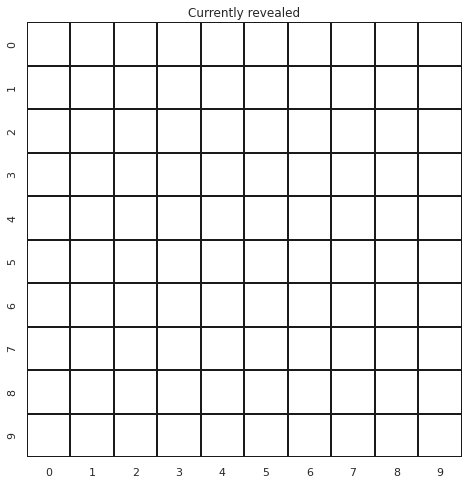

Enter row to guess:  5
Enter column to guess:  4


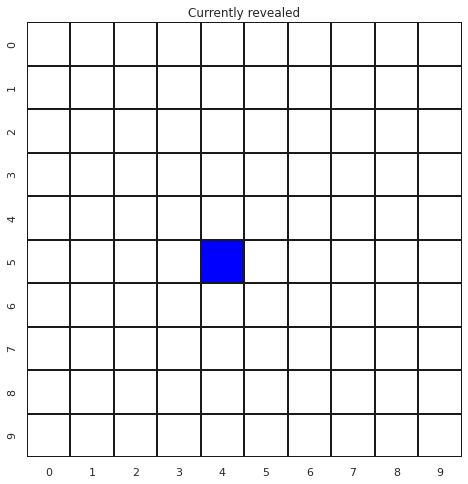

Enter row to guess:  0
Enter column to guess:  3


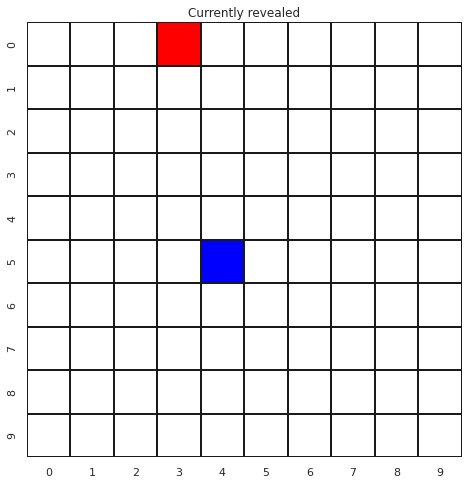

Enter row to guess:  1
Enter column to guess:  3


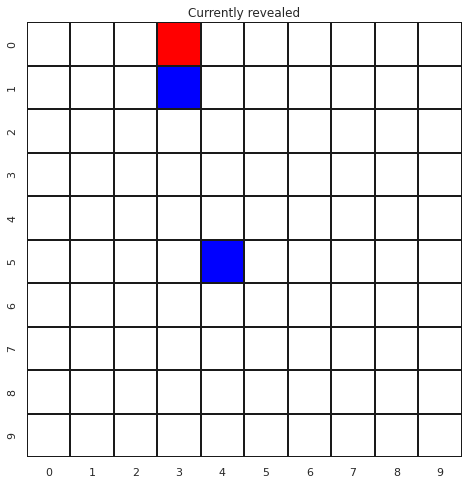

Enter row to guess:  0
Enter column to guess:  2


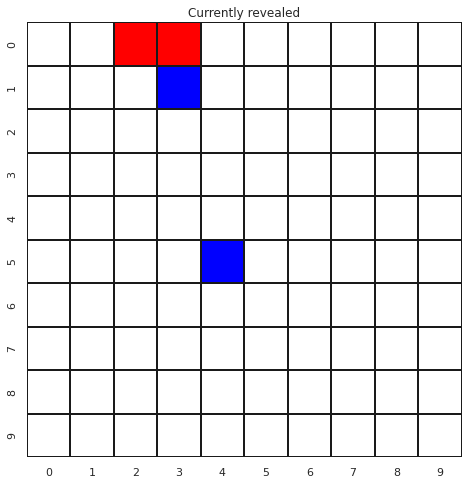

Enter row to guess:  0
Enter column to guess:  4


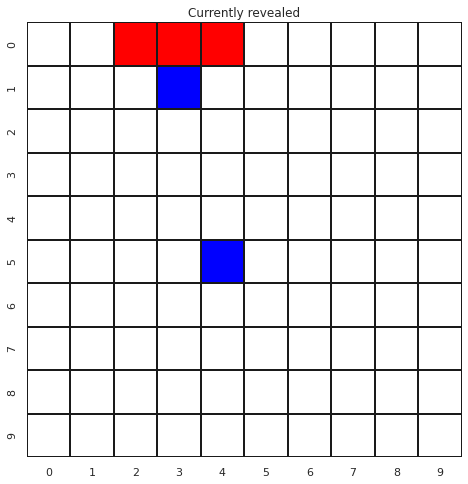

Game ended


In [17]:
try:
    play(ships, ManualStrategy())
except KeyboardInterrupt:
    print("Game ended")

This strategy is not really useful for our purposes, but it provides a good illustration of how the game is usually played.  The white squares here indicate the cells whose contents are unknown because we have not yet guessed them.

### Row with one ship

We begin by simplifying the idea of Battleship to the most basic possible setting of a single row containing a single ship.

The following function generates all possible rows of a given length containing a ship of a given size.

In [18]:
def get_all_ship_rows(grid_length, ship_size):
    i, j = np.indices((grid_length, grid_length))[:, :-ship_size + 1]
    
    return 1 * (i <= j) & (j < i + ship_size)

For a row of length three and a ship of size two (3/2), there are only two such rows.

In [19]:
all_rows_3_2 = get_all_ship_rows(3, 2)

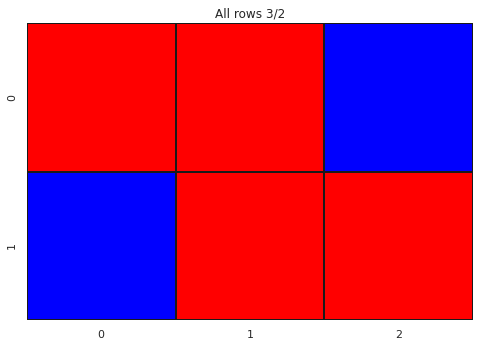

In [20]:
ax = plot_board(all_rows_3_2)
ax.set_title("All rows 3/2");

For a row of length ten and a ship of size four (10/4), there are seven such rows.

In [21]:
all_rows_10_4 = get_all_ship_rows(10, 4)

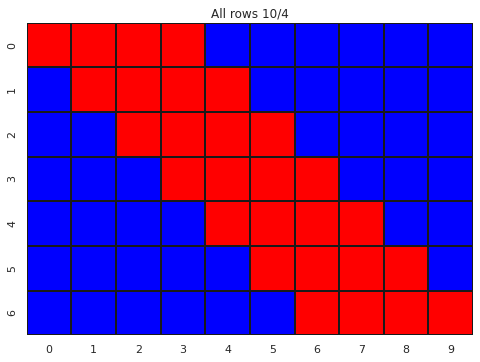

In [22]:
ax = plot_board(all_rows_10_4)
ax.set_title("All rows 10/4");

We will compare our Bayesian strategies to several benchmark strategies, starting with the simplest possible strategy: random guessing.

#### Random guessing

The random guessing approach to Battleship is equivalent to the following urn problem from classic probability theory.  Imagine an urn containing 100 balls (corresponding to cells on the board), 17 of which are red (corresponding to cells covered by ships), and 83 of which are blue.  The number of turns required to solve Battleship through random guessing has the same distribution as the number of balls of any color that are drawn before all 17 red balls have been drawn.  It is well known (in the right circles, at least) that this corresponds to the [negative hypergeometric distribution](https://en.wikipedia.org/wiki/Negative_hypergeometric_distribution).

<center>
<figure>
    <img src="https://austinrochford.com/resources/battleship_files/neg_hyp_geo.png" width=500>
    <caption>Original image credit <a href="https://www.johndcook.com/blog/distribution_chart/">John D. Cook</a></caption>
</figure>
</center>

The following function returns the probability mass function (pmf) of the appropriate negative hypergeometric distribution given a grid and ship size.

In [23]:
def get_random_guess_dist(grid_size, ship_size, n_hit=None):
    if n_hit is None:
        n_hit = ship_size

    support = np.arange(ship_size, grid_size + 1)
    nhg = stats.nhypergeom(grid_size,
                           grid_size - ship_size,
                           n_hit)
    
    return Pmf(nhg.pmf(support - ship_size), support)

We see, unsurprisingly, that random guessing will usually take near the maximum number of turns to solve the game.

In [24]:
std_random_pmf = get_random_guess_dist(GRID_LENGTH**2, SHIP_SIZES.sum())

In [25]:
def plot_turn_dist(pmf, kind='bar', mean=False, ax=None, mean_kwargs=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
        
    if kind == 'bar':
        # pandas barplot uses odd indexing, making it hard to
        # mix bar and line plots if we use pandas's versions
        kwargs.setdefault('width', 1)
        kwargs.setdefault('alpha', 0.75)

        ax.bar(pmf.index, pmf, **kwargs)
    elif kind == 'line':
        pmf.plot(ax=ax, **kwargs)
    else:
        raise ValueError("kind must be one of 'bar' or 'line'")    
        
    if mean:
        if mean_kwargs is None:
            mean_kwargs = {}
            
        mean_kwargs.setdefault('ls', '--')
        
        ax.axvline(pmf.mean(), **mean_kwargs);
    
    ax.xaxis.grid(False)
    ax.set_xlabel("Turns")
    
    return ax

In [26]:
def make_pct_yaxis(ax):
    ax.yaxis.set_major_formatter(pct_formatter)
    ax.set_ylabel("Probability")
    
    return ax

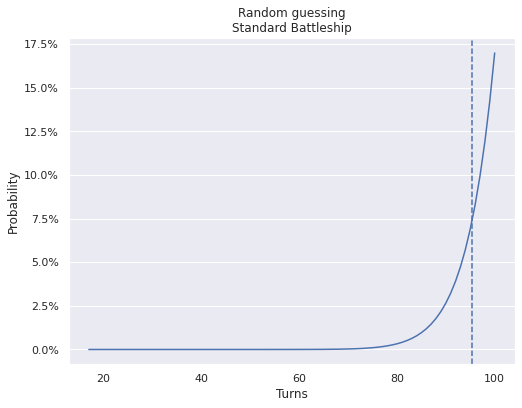

In [27]:
std_turn_ax = plot_turn_dist(std_random_pmf, kind='line', mean=True)
    
make_pct_yaxis(std_turn_ax);
std_turn_ax.set_title("Random guessing\nStandard Battleship");

The dashed vertical line shows the expected number of turns to solve Battleship by randomly guessing,

In [28]:
std_random_pmf.mean()

95.38888888888883

Returning the the case of a row with a single ship, we visualize the turn distribution of random guessin strategies for various row lengths and a ship of size two.

In [29]:
RANDOM_ROW_LENGTHS = [4, 5, 8, 10]

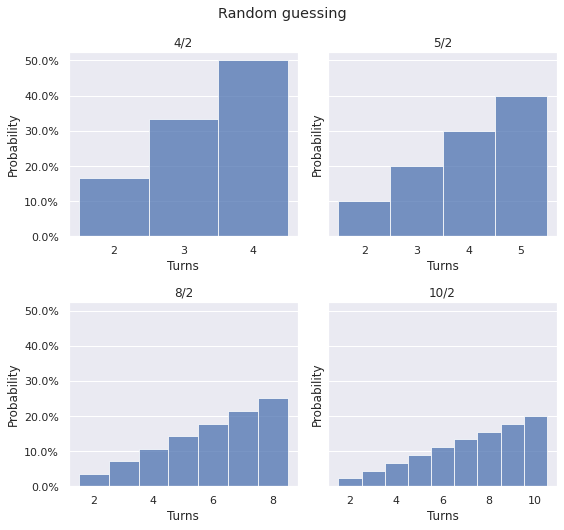

In [30]:
fig, axes = plt.subplots(nrows=len(RANDOM_ROW_LENGTHS) // 2, ncols=2,
                         sharey=True,
                         figsize=(FIG_WIDTH, 1.25 * FIG_HEIGHT))

for (row_length, ax) in zip(RANDOM_ROW_LENGTHS, axes.flat):
    pmf = get_random_guess_dist(row_length, 2)
    plot_turn_dist(pmf, ax=ax);
    
    make_pct_yaxis(ax);
    ax.set_title(f"{row_length}/2");

fig.suptitle("Random guessing");
fig.tight_layout();

We do the same for a ship of size three.

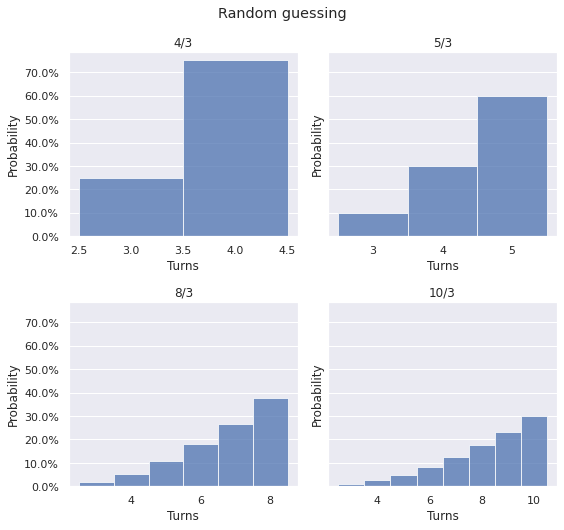

In [31]:
fig, axes = plt.subplots(nrows=len(RANDOM_ROW_LENGTHS) // 2, ncols=2,
                         sharey=True,
                         figsize=(FIG_WIDTH, 1.25 * FIG_HEIGHT))

for (row_length, ax) in zip(RANDOM_ROW_LENGTHS, axes.flat):
    pmf = get_random_guess_dist(row_length, 3)
    plot_turn_dist(pmf, ax=ax);
    
    make_pct_yaxis(ax);
    ax.set_title(f"{row_length}/3");

fig.suptitle("Random guessing");
fig.tight_layout();

As with the case of standard Battleship, the most likely outcome is to use all the turns, and the expected value will be slightly below that.

#### Optimal search

In the simple setting of a row with a single ship, it is not too hard to work out the optimal search strategy, which consists of two phases.  First we must locate the ship by getting at least one hit.  Once the ship has been located, we must sink it by attacking spaces next to known hits until all of the ship has been found.

##### After at least one hit

We first implement optimal search after at least one hit has occurred.  In this case, we guess the spot immediately to the left of the leftmost hit, unless that hit is in the first cell, or the cell to its left has already been shown to contain water.  In those two cases, we guess the cell to the right of the rightmost hit until all cells containing the ship have been hit.  The following function implements this strategy.

In [32]:
def next_guess_1d_with_hit(row):
    first = row.argmax()

    # found the left edge, fill out the ship to the right
    if first == 0 or row[first - 1] == 0:
        return first + row[first:].mask.argmax()
    # find the left edge
    else:
        return first - 1

We can show how this strategy works through a simple animated example.  Suppose the position of a length three ship on a length ten row is as shown below.

In [33]:
board = np.zeros(10)
board[6:9] = 1

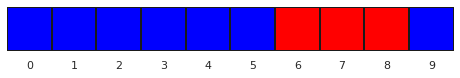

In [34]:
plot_board(board);

Also suppose that after three guesses, the following spots have been revealed.

In [35]:
revealed = np.ma.masked_all_like(board)
revealed[[1, 4, 7]] = board[[1, 4, 7]]

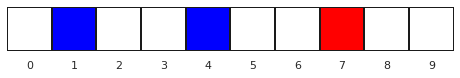

In [36]:
plot_board(revealed);

The above strategy will take three guesses to sink the ship, as shown in the animation below.

In [37]:
turn_revealed = [revealed]

next_j = next_guess_1d_with_hit(revealed)
next_revealed = revealed.copy()
next_revealed[next_j] = board[next_j]
turn_revealed.append(next_revealed)
revealed = next_revealed

next_j = next_guess_1d_with_hit(revealed)
next_revealed = revealed.copy()
next_revealed[next_j] = board[next_j]
turn_revealed.append(next_revealed)
revealed = next_revealed

next_j = next_guess_1d_with_hit(revealed)
next_revealed = revealed.copy()
next_revealed[next_j] = board[next_j]
turn_revealed.append(next_revealed)
revealed = next_revealed

In [38]:
def animate_boards(boards,
                   cmap=CMAP, cbar=False, ax=None,
                   heatmap_kwargs=None, **ani_kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
    else:
        fig = ax.figure
        
    if heatmap_kwargs is None:
        heatmap_kwargs = {}
        
    plot_board(boards[0],
               cmap=cmap, cbar=cbar, ax=ax,
               **heatmap_kwargs)
    
    quadmesh, *_ = ax.get_children()
    
    def ani_func(i):
        quadmesh.set_array(boards[i])
        
        return quadmesh,
    
    ani_kwargs.setdefault('blit', True)
    ani_kwargs.setdefault('frames', len(boards))
    
    return FuncAnimation(fig, ani_func, **ani_kwargs)

In [39]:
%%capture
ani = animate_boards(turn_revealed, interval=300)

In [40]:
HTML(ani.to_html5_video())

##### Getting the first hit

Immediately it is clear that we only have to search one of the conrguence classes of the cell index mod the ship size to guarantee a hit.  In the following plot of a row of length ten, each congruence class mod three is colored differently.

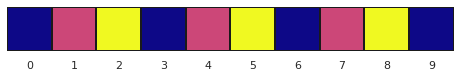

In [41]:
plot_board(np.arange(10) % 3, cmap='plasma', vmin=0, vmax=2);

A moment's consideration shows that the congruence class of -1 modulo the ship size will always have the fewest elements of any of the congruence class, so we choose to search along these cells.  The following plot shows the cells to be searched until a hit is found in red.

In [42]:
def get_search_cells_1d(grid_length, ship_size):
    i = np.arange(grid_length)
    
    return i[i % ship_size == -1 % ship_size]

In [43]:
row = np.zeros(10)
row[get_search_cells_1d(10, 3)] = 1

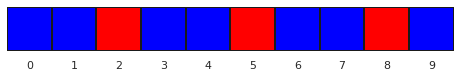

In [44]:
plot_board(row);

The following subclass of `Strategy` implements the optimal strategy of searching along this grid until a hit is found, then greedily filling out the ship.

In [45]:
class Single1DOptimalStrategy(Strategy):
    def __init__(self, grid_length, ship_size):
        self._grid_length = grid_length
        self._ship_size = ship_size
        
    def next_guess(self, revealed):
        if revealed.mask.all() or revealed.sum() == 0:
            search_j = get_search_cells_1d(self._grid_length,
                                           self._ship_size)            
            next_j = search_j[revealed.mask[0, search_j].argmax()]
        else:
            return 0, next_guess_1d_with_hit(revealed[0])
                
        return 0, next_j

We now use this strategy to play all three games with a length three ship on a length five row.

In [46]:
all_rows_5_3 = get_all_ship_rows(5, 3)

In [47]:
opt_row_games_5_3 = [
    play(ship_row[np.newaxis, np.newaxis],
         Single1DOptimalStrategy(5, 3))
        for ship_row in all_rows_5_3
]
opt_row_turns_5_3 = Pmf.from_seq([game.turns for game in opt_row_games_5_3])

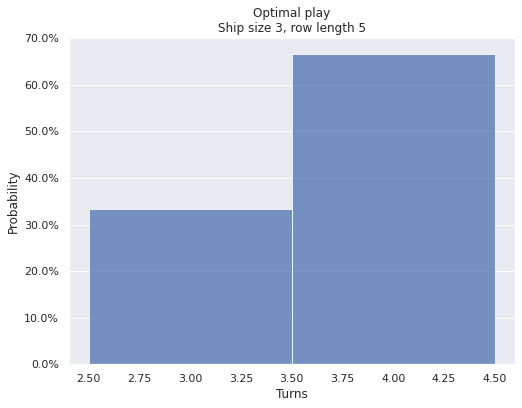

In [48]:
ax = plot_turn_dist(opt_row_turns_5_3)

make_pct_yaxis(ax);
ax.set_title("Optimal play\nShip size 3, row length 5");

Two of the games take four turns and one takes three turns.  Notably, no games take five turns. This is because we know that the third cell is a guaranteed hit in this configuration.

We can repeat this exercise for a row of length ten.

In [49]:
all_rows_10_3 = get_all_ship_rows(10, 3)

In [50]:
opt_row_games_10_3 = [
    play(ship_row[np.newaxis, np.newaxis],
         Single1DOptimalStrategy(10, 3))
        for ship_row in all_rows_10_3
]
opt_row_turns_pmf_10_3 = Pmf.from_seq([game.turns for game in opt_row_games_10_3])

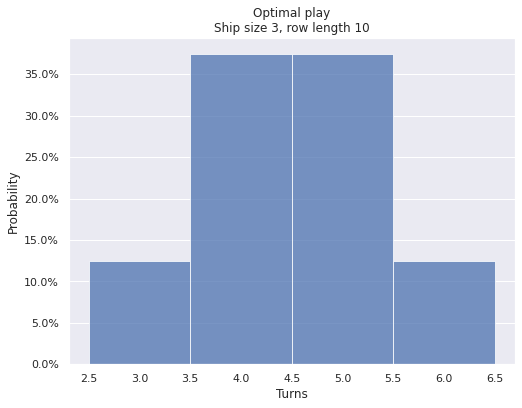

In [51]:
ax = plot_turn_dist(opt_row_turns_pmf_10_3)

make_pct_yaxis(ax);
ax.set_title("Optimal play\nShip size 3, row length 10");

We see that no games take more than six turns with this configuration.  Since the equivalence class of -1 modulo 3 contains three members (2, 5, and 8), we are guaranteed to get our first hit in at most three guesses, and once we have a first hit it will take at most three guesses to sink the ship (two hits and potentially one miss if the first hit was not on the rightmost cell of the ship).

#### Bayesian (Thompson sampling)

The above thought exercise is interesting, but it involves several domain-specific insights (the optimal search grid, how to optimally sink a ship that has been located) that do not generalize immediately to two-dimensional grids that allow ships to be oriented in either rows or columns. (Note that if we restrict our ship in an $m \times n$ grid to be oriented along a row, we're essentially playing a one-dimensional game on a row of length $m \cdot n$.)  In this section we will show how to reproduce the above results using a Bayesian approach to this game of simplified Battleship.  This approach will generalize to a near-optimal strategy for standard Battleship with many fewer hard coded rules than the above optimal one-dimensional strategy requires to generalize.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/1280px-Bayes%27_Theorem_MMB_01.jpg" width=500></center>

We begin by enumerating all possible boards for a given row/ship configuration (in this case 5/3).

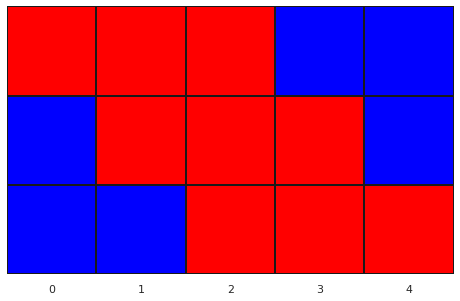

In [52]:
ax = plot_board(all_rows_5_3)
ax.set_yticklabels([]);

We consider this set of ships as a uniform prior distribution on the set of possible board layouts. With this perspective, when we take the average in each columns, we get the prior probability that each cell contains a ship.

We already see that this Bayesian approach thhat we can conclude that the third cell must contain a ship without doing any modular arithmetic. 

For a configuration with a longer row (10/3), we see that the middle six cells have the higest prior probability of containing a ship.  This makes sense as there are three configurations in which each of these cells contains a ship, but only one configuration in which the first cell contains a ship, and similarly for the other cells near the edges.

In [53]:
all_rows_10_3 = get_all_ship_rows(10, 3)

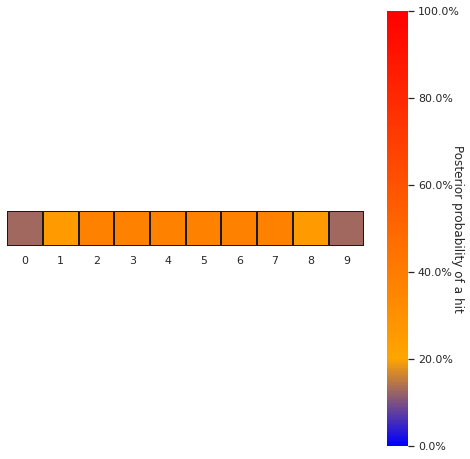

In [54]:
plot_board(all_rows_10_3.mean(axis=0), cbar=True);

Looking at these probabilities, a resonable strategy would seem to be to guess the next cell with the highest probability of containing a hit.  In both the 5/3 and 10/3 cases, this would result in guessing the third cell next. (By convention when many cells have the same hit probability, we will choose the one wit smallest coordinates.)

Let's focus on the 5/3 configuration for the moment and return to 10/3 after.  Suppose the true 5/3 board is as follows.

In [55]:
board_5_3 = np.zeros(5)
board_5_3[1:4] = 1

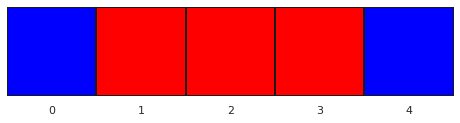

In [56]:
plot_board(board_5_3);

Guessing the third cell must result in a hit in the 5/3 configuration, so after one guess the following board has been revealed.

In [57]:
revealed_5_3 = np.ma.masked_all_like(board_5_3)
revealed_5_3[2] = board_5_3[2]

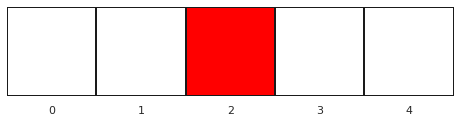

In [58]:
plot_board(revealed_5_3);

With this information, what should our next guess be?  For the first guess we chose the cell with the highest prior probability of yielding a hit, so it seems intuitive that we would choose the cell with the highest _posterior_ probability of yielding a hit, given the observation from our first guess.

We can get this posterior distribution by eliminating the boards that do not match the cells that have been revealed to us.

In [59]:
def is_compat(ships, revealed, board_axis=(-2, -1)):
    return (ships == revealed).all(axis=board_axis)

In [60]:
compat_5_3 = all_rows_5_3[
    is_compat(all_rows_5_3, revealed_5_3, board_axis=-1)
]

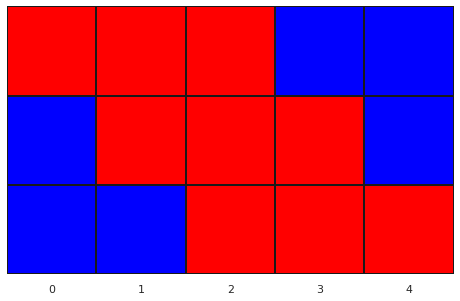

In [61]:
ax = plot_board(compat_5_3)
ax.set_yticklabels([]);

Since the third cell is guaranteed to be a hit in the 5/3 configuration, all ship layouts are compatible with the result of our first guess, and the posterior is the same as the prior _restricted to unknown cells_.  With this restriction our posterior is as follows.

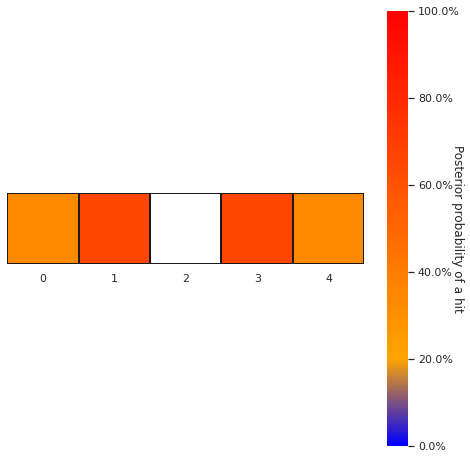

In [62]:
plot_board(
    np.ma.masked_array(compat_5_3.mean(axis=0),
                       mask=~revealed_5_3.mask),
    cbar=True
);

We see that out of all the unknown cells, the second and third are tied for the highest posterior probability of being a hit.  By our convention, we will choose the second cell as the next guess, which we know will reveal a hit.

In [63]:
revealed_5_3[1] = board_5_3[1]

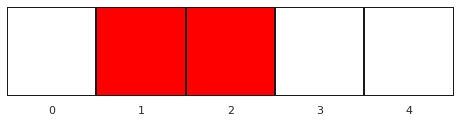

In [64]:
plot_board(revealed_5_3);

With this observations we are able to eliminate one of the potential boards.

In [65]:
compat_5_3 = all_rows_5_3[
    is_compat(all_rows_5_3, revealed_5_3, board_axis=-1)
]

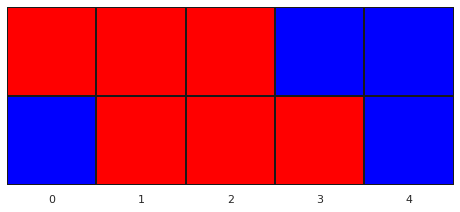

In [66]:
ax = plot_board(compat_5_3)
ax.set_yticklabels([]);

Combining these two compatible boards to form the posterior distribution, we get the following.

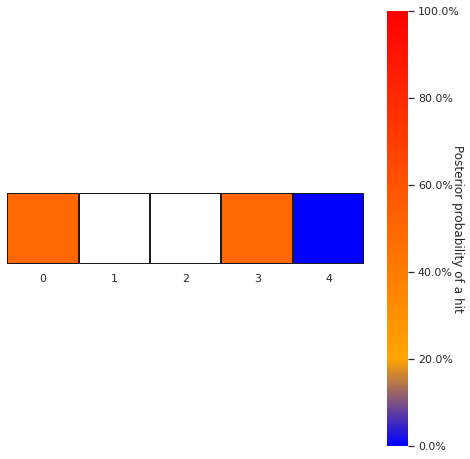

In [67]:
ax = plot_board(
    np.ma.masked_array(compat_5_3.mean(axis=0),
                       mask=~revealed_5_3.mask),
    cbar=True
)
ax.set_yticklabels([]);

We see that it is impossible for the fourth cell to contain a hit, and there's a 50% chance that the first and fourth cells will be a hit.  By our convention above, we guess the first cell, resulting in a miss.

In [68]:
revealed_5_3[0] = board_5_3[0]

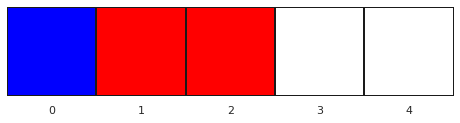

In [69]:
plot_board(revealed_5_3);

Finally we see that there is only one board compatible with the information that has been revealed, so we guess the fourth cell to end the game.

In [70]:
compat_5_3 = all_rows_5_3[
    is_compat(all_rows_5_3, revealed_5_3, board_axis=-1)
]

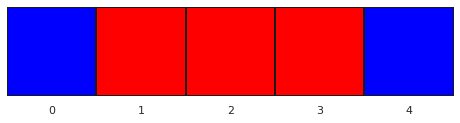

In [71]:
ax = plot_board(compat_5_3)
ax.set_yticklabels([]);

We now return to the 10/3 case.  Suppose we are working with the following board.

In [72]:
board_10_3 = np.zeros(10)
board_10_3[5:8] = 1

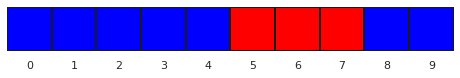

In [73]:
plot_board(board_10_3);

Recalling the prior distribution on hits in the 10/3 configuration, we see first guess the third cell, revealing a miss.

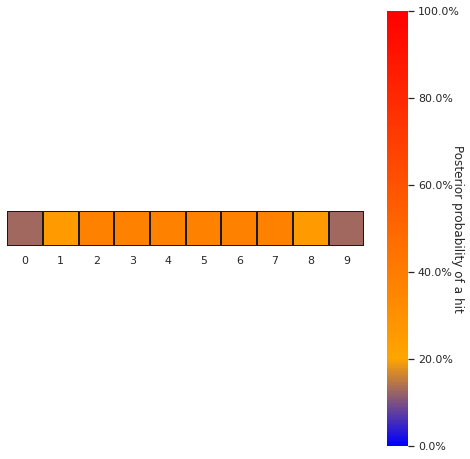

In [74]:
plot_board(all_rows_10_3.mean(axis=0), cbar=True);

In [75]:
revealed_10_3 = np.ma.masked_all_like(board_10_3)
revealed_10_3[2] = board_10_3[2]

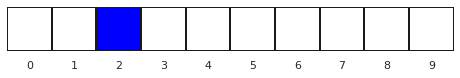

In [76]:
plot_board(revealed_10_3);

Excluding boards that are incompatible with a miss in the third cell, we see that we have already ruled out a ship in the first two cells as well.

In [77]:
compat_10_3 = all_rows_10_3[
    is_compat(all_rows_10_3, revealed_10_3, board_axis=-1)
]

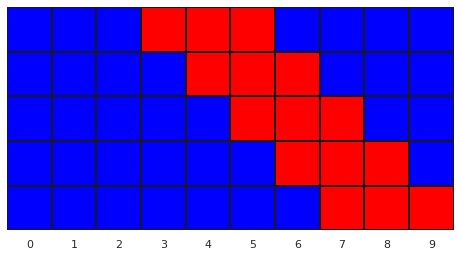

In [78]:
ax = plot_board(compat_10_3)
ax.set_yticklabels([]);

Unsurprisingly, the sixth through eight cells are tied for the highest probability of yielding a hit, so we guess the six cell, revealing a hit.

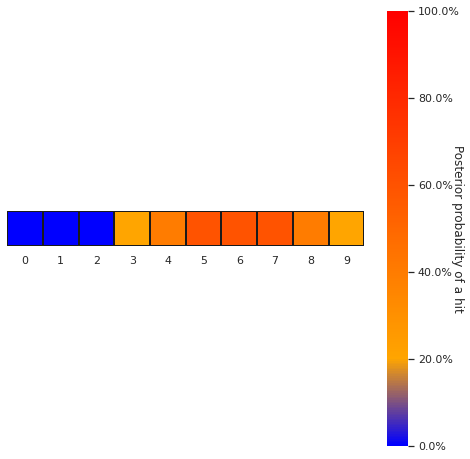

In [79]:
plot_board(compat_10_3.mean(axis=0), cbar=True);

In [80]:
revealed_10_3[5] = board_10_3[5]

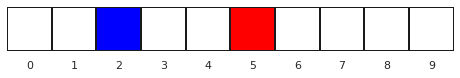

In [81]:
plot_board(revealed_10_3);

Hitting the rest of the ship will proceed similarly to the 5/3 case, so we stop playing here.

This approach of calculating the posterior distribution by enumerating the possible grids and eliminating those that are incompatible with the observed hits and misses is a very simple type of [approximate Bayesian computation](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation) (ABC).  ABC is a fascinating and deep field of research in its own right, and we are really only scratching its surface here.

Choosing to guess the cell with the [maximum a posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) is a simplified (greedy) form of [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling), a Bayesian approach to playing games of incomplete information that chooses the next action according to the probability that it maximizes the expected reward.  In the simple situation of a single ship (in both one and two dimensions) we can calculate the cell(s) that has the MAP probability chance of yielding a hit (the expected reward) exactly, so this strategy becomes greedy.  (I have a soft spot for Thompsons sampling in general as we use it in a number of our machine-learning based products at [Kibo](https://kibocommerce.com/), where I work.  For a discussion of the applications of Thompson sampling to e-commerce optimization, take a look at my [talks](https://austinrochford.com/talks.html).)

In [82]:
def argmax_2d(x):
    max_i = x.max(axis=1).argmax()
    max_j = x[max_i].argmax()
    
    return max_i, max_j

In [83]:
class SingleThompsonStrategy(Strategy):
    def __init__(self, poss_ships):
        self._poss_ships = poss_ships
    
    def compat_ships(self, revealed):
        if revealed.mask.all():
            return self._poss_ships
        else:
            is_compat_ = is_compat(self._poss_ships, revealed)

            return self._poss_ships[is_compat_]
    
    def next_guess(self, revealed):
        post = np.ma.masked_array(
            self.compat_ships(revealed).mean(axis=0),
            mask=~revealed.mask
        )
        
        return argmax_2d(post)

We watch this strategy play the game we started above.

In [84]:
ts = SingleThompsonStrategy(all_rows_10_3[:, np.newaxis, :])
game_10_3 = play(board_10_3[np.newaxis, np.newaxis, :], ts,
                 progress_bar=True)

100%|██████████| 3/3 [00:00<00:00, 391.81it/s]


In [85]:
%%capture
ani = animate_boards(game_10_3.turn_revealed)

In [86]:
HTML(ani.to_html5_video())

As with our optimal row strategy, we can play every possible 10/3 game with the Thompson sampling strategy and compare the distributions of the number of turns.

In [87]:
ts_row_games_10_3 = [
    play(row[np.newaxis, np.newaxis],
         SingleThompsonStrategy(all_rows_10_3[:, np.newaxis, :]))
        for row in all_rows_10_3
]
ts_row_turns_pmf_10_3 = Pmf.from_seq([
    game.turns for game in ts_row_games_10_3
])

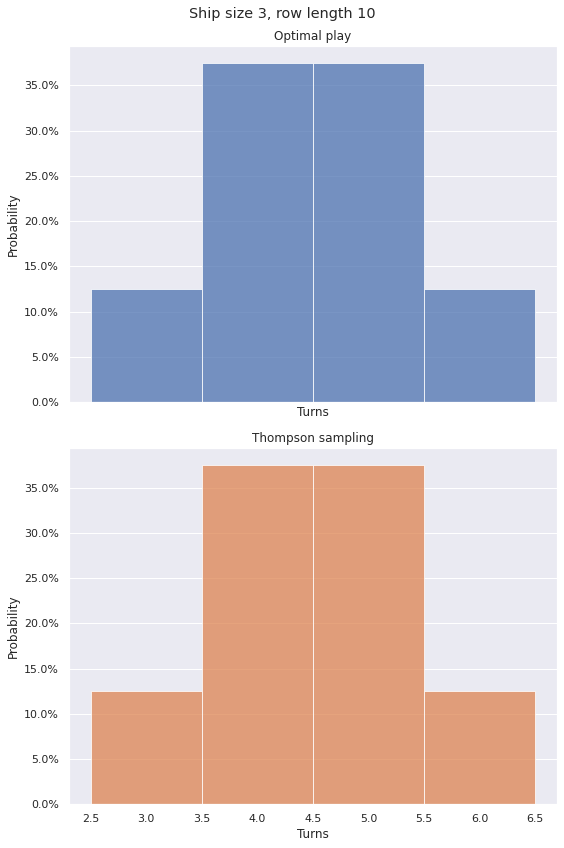

In [88]:
fig, (opt_ax, ts_ax) = plt.subplots(nrows=2, sharex=True, sharey=True,
                                    figsize=(FIG_WIDTH, 2 * FIG_HEIGHT))

plot_turn_dist(opt_row_turns_pmf_10_3, color='C0', ax=opt_ax);

make_pct_yaxis(opt_ax);
opt_ax.set_title("Optimal play");

plot_turn_dist(ts_row_turns_pmf_10_3, color='C1', ax=ts_ax);

make_pct_yaxis(ts_ax);
ts_ax.set_title("Thompson sampling");

fig.suptitle("Ship size 3, row length 10");
fig.tight_layout();

It turns out that for a single row with a single ship, the Thompson sampling strategy is optimal!

<center>
<figure>
    <img src="https://sinmantyx.files.wordpress.com/2015/05/m6xj1.jpg">
    <caption>Image credit <a href="https://sinmantyx.wordpress.com/2015/05/29/bayes-theorem-205-hypothesis-fever-and-falsification/">SINMANTYX</a></caption>
</figure>
</center>

It is extremely cool to me that we can reproduce the optimal strategy without too much domain-specific thought, but just by enumerating all possible boards and sequentially eliminating the ones that are no longer compatible with the observed (revealed) data!  This result is particularly exciting because, as we will see, the generalization of the row-optimal strategy to a two-dimensional grid is not straightforward (even for just one ship), but the Thompson sampling approach generalizes much more readily.

### Square, one ship

We now turn to the case of a square grid with one ship on it to see how these strategies generalize to something closer to standard Battleship.

#### Random guessing

Once again the number of turns it takes to sink the ship follows a negative hypergeometric distribution.  For the 5/5/3 configuration, this distribution is shown below.

In [89]:
random_5_5_3_pmf = get_random_guess_dist(5**2, 3)

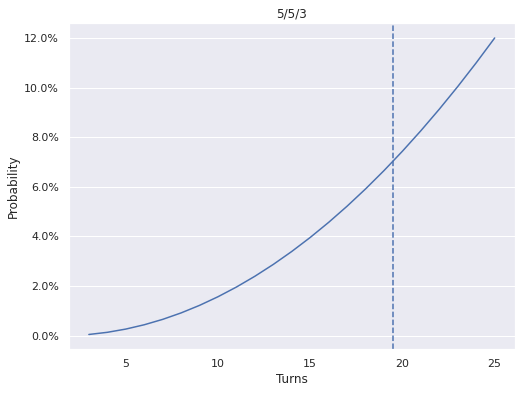

In [90]:
ax = plot_turn_dist(random_5_5_3_pmf, kind='line', mean=True)

make_pct_yaxis(ax);
ax.set_title(r"5/5/3");

There are not really any surprises here; the geometry of the board and the ability to have ships orient along rows or columns doesn't affect the random guessing strategy at all.

#### Near optimal

We now construct a near optimal strategy for one ship on a two-dimensional grid based on trying to reduce the problem to search on a one-dimensional row/column as quickly as possible.  We call this strategy "near optimal" because we will see that it takes slightly more turns, on average, than a Thompson sampling strategy to sink the ship.

It is tempting to treat an $m \times n$ two-dimensional grid as a $m \cdot n$ one-dimensional grid and use the search grid from the above strategy, but this grid will only minimize the turns-to-first-hit when $m$ and $n$ are [relatively prime](https://en.wikipedia.org/wiki/Coprime_integers).  To illustrate this fact, we show the results of wrapping the search grid for the 100/2 configuration to the 10/10/2 configuration below.

In [91]:
bad_search_j_1d = get_search_cells_1d(100, 2)
bad_search_i, bad_search_j = np.divmod(bad_search_j_1d, 10)
bad_search_grid = np.zeros((10, 10))
bad_search_grid[bad_search_i, bad_search_j] = 1

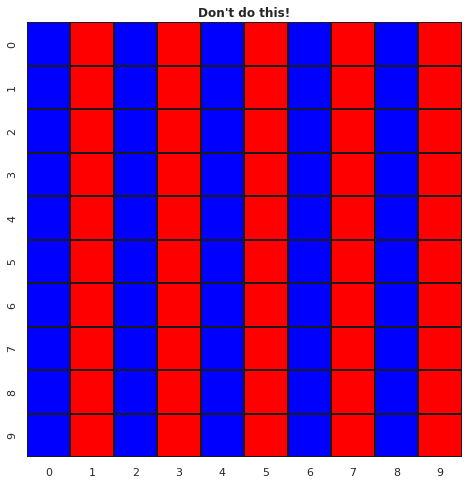

In [92]:
ax = plot_board(bad_search_grid)
ax.set_title(r"Don't do this!", fontweight='bold');

Clearly this search strategy can fail to locate a column-oriented ship in an even-numbered column even after fifty guesses!

Instead, the optimal grid to search for the initial hit (at least for a square grid) is to cycle through the equivalence classes modulo the ship size in each row, as shown below for both the 10/10/2 and the 5/5/3 configurations.

In [93]:
def get_search_cells_2d(grid_shape, ship_size):
    i, j = np.indices(grid_shape)
    in_grid = (i - 1) % ship_size == j % ship_size
    
    return i[in_grid], j[in_grid]

In [94]:
search_i, search_j = get_search_cells_2d((10, 10), 2)
search_grid = np.zeros((10, 10))
search_grid[search_i, search_j] = 1

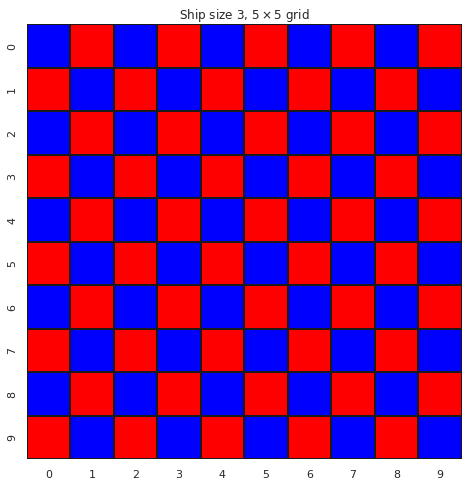

In [95]:
ax = plot_board(search_grid)
ax.set_title(r"Ship size 3, $5 \times 5$ grid");

In [96]:
search_i, search_j = get_search_cells_2d((5, 5), 3)
search_grid = np.zeros((5, 5))
search_grid[search_i, search_j] = 1

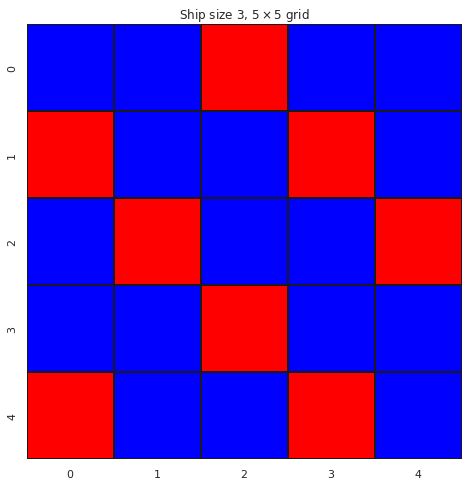

In [97]:
ax = plot_board(search_grid)
ax.set_title(r"Ship size 3, $5 \times 5$ grid");

We can tell that these search grids are optimal because each cell highlighted in red is one cell less than the ship shize away from any other hightlighted cell.

Once a hit has been found by searching these cells, we have to determine if the ship is oriented along the row or column passing through that cell.  For hits near a boundary (in cells less than a ship's length away from either the top/bottom or left/right edge) we only have to test one cell to decide which way the ship is oriented.  For hits at the interior we have to, in general, test two adjacent cells (either left and right or above and below) to determine the orientation of the ship.

The following plot highlights the cells that only require one test guess to determine the row/column orientation following a hit for the 10/10/3 configuration.

In [98]:
near_edge = np.zeros((10, 10))
i, j = np.indices((10, 10))
near_edge[(i < 2) | (7 < i) | (j < 2) | (7 < j)] = 1

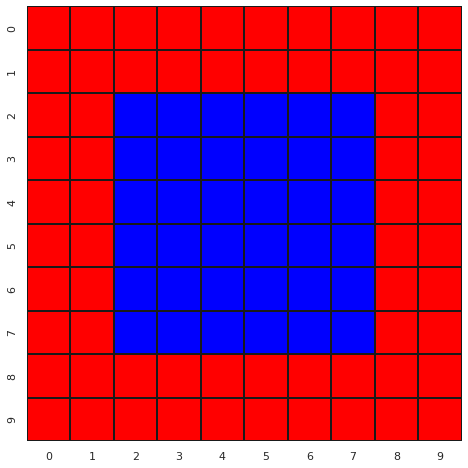

In [99]:
plot_board(near_edge);

The strategy outlined here is implemented below.

In [100]:
class SingleGridStrategy(Strategy):
    def __init__(self, ship_size):
        self._ship_size = ship_size

    def next_guess(self, revealed):
        if revealed.mask.all() or revealed.sum() == 0:
            next_unmasked = (revealed.mask
                                     [search_i, search_j]
                                     .argmax())

            return search_i[next_unmasked], search_j[next_unmasked]
        else:
            grid_length, _ = revealed.shape
            hit_i, hit_j = argmax_2d(revealed)
            ship_size = self._ship_size
            
            if revealed.sum() == 1:                
                if hit_i < ship_size - 1 or grid_length - ship_size < hit_i:
                    next_i = hit_i + (1 if hit_i < ship_size - 1 else -1)
                    
                    if revealed.mask[next_i, hit_j]:
                        return next_i, hit_j
                    else:
                        is_row = revealed[next_i, hit_j] == 0
                elif hit_j < ship_size - 1 or grid_length - ship_size < hit_j:
                    next_j = hit_j + (1 if hit_j < ship_size - 1 else -1)
                    
                    if revealed.mask[hit_i, next_j]:
                        return hit_i, next_j
                    else:
                        is_row = revealed[hit_i, next_j] == 1
                elif revealed.mask[hit_i, hit_j - 1]:
                    return hit_i, hit_j - 1
                elif revealed.mask[hit_i, hit_j + 1]:
                    return hit_i, hit_j + 1
                else:
                    is_row = False
            else:                
                is_row = revealed[hit_i].sum() > 1
                
            if is_row:
                return hit_i, next_guess_1d_with_hit(revealed[hit_i])
            else:
                return next_guess_1d_with_hit(revealed[:, hit_j]), hit_j

This strategy involves quite a bit of branching logic and more than a few magic numbers.  While I do not doubt that this implementation can be simplified, avoiding complex branching logic is one of the motivations for a simulation-based Bayesian approach to Battleship.

To understand the distribution of turns required by this strategy to sink the ship, we define a function that generates all square grids of a given shape with a single ship of a given size.

In [101]:
def get_all_ships(grid_length, ship_size):
    rows = get_all_ship_rows(grid_length, ship_size)
    n_rows, _ = rows.shape
    
    i = np.arange(grid_length)

    boards = np.zeros((
        n_rows, grid_length,
        grid_length, grid_length,
    ))
    boards[:, i, i, :] = rows[:, np.newaxis]
    long_boards = boards.reshape((-1, grid_length, grid_length))
    
    return np.concatenate((
        long_boards,
        long_boards.transpose(0, 2, 1)
    ))

We generate all possible boards for the 5/5/3 configuration and visualize a few of them.

In [102]:
all_ships_5_5_3 = get_all_ships(5, 3)

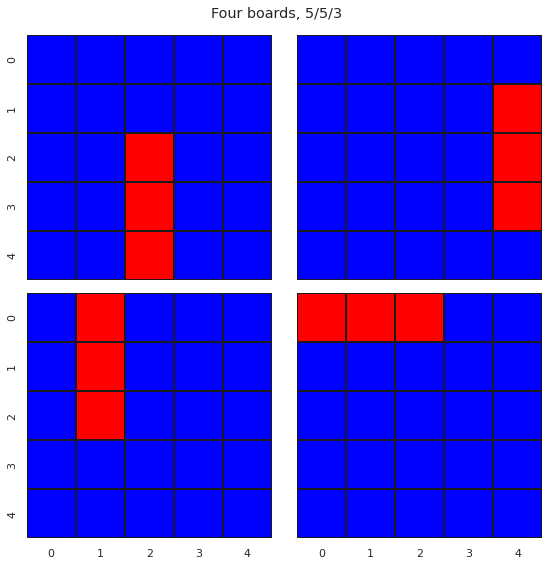

In [103]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(FIG_WIDTH, FIG_WIDTH))

plt_boards = rng.choice(all_ships_5_5_3, size=axes.size, replace=False)

for (board, ax) in zip(plt_boards, axes.flat):
    plot_board(board, ax=ax);

fig.suptitle("Four boards, 5/5/3");
fig.tight_layout();

We now play all 5/5/3 games using this strategy.

In [104]:
grid_games_5_5_3 = [
    play(ship[np.newaxis], SingleGridStrategy(3))
        for ship in all_ships_5_5_3
]
grid_turns_pmf_5_5_3 = Pmf.from_seq([
    game.turns for game in grid_games_5_5_3
])

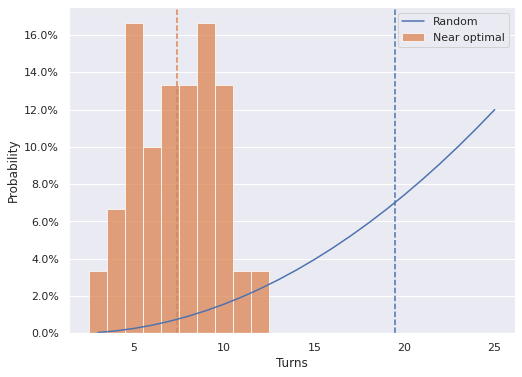

In [105]:
ax = plot_turn_dist(grid_turns_pmf_5_5_3,
                    color='C1', label="Near optimal",
                    mean=True, mean_kwargs={'c': 'C1'});
plot_turn_dist(random_5_5_3_pmf,
               kind='line', c='C0',
               mean=True, mean_kwargs={'c': 'C0'},
               label="Random",
               ax=ax)

make_pct_yaxis(ax);

ax.legend();

We see that this near optimal strategy is an significant improvement over random guessing (which is expected). Intuitively, it seems odd that the distribution is bimodal.  In fact, we will see after implementing Thompson sampling in the two-dimensional case, that this strategy is definitely not optimal.

#### Bayesian (Thompson sampling)
 
The generalization of one-dimensional Thompson sampling to a two-dimensional grid is much simpler than the above generalization of the one-dimensional optimal strategy.  The implementation of Thompson sampling for a single ship in two dimensions is shown below.

In [106]:
class SingleThompsonStrategy(Strategy):
    def __init__(self, poss_ships):
        self._poss_ships = poss_ships
    
    def compat_ships(self, revealed):
        if revealed.mask.all():
            return self._poss_ships
        else:
            is_compat_ = is_compat(self._poss_ships, revealed)

            return self._poss_ships[is_compat_]
    
    def next_guess(self, revealed):
        post = np.ma.masked_array(
            self.compat_ships(revealed).mean(axis=0),
            mask=~revealed.mask
        )
        
        return argmax_2d(post)

We now play all 5/5/3 games with this strategy to understand its turn distribution.

In [107]:
ts_games_5_5_3 = [
    play(ship[np.newaxis], SingleThompsonStrategy(all_ships_5_5_3))
        for ship in all_ships_5_5_3
]
ts_turns_pmf_5_5_3 = Pmf.from_seq([
    game.turns for game in ts_games_5_5_3
])

As alluded to above, we see that the turn distribution for Thompson sampling is concentrated to the left of the turn distribution for our near optimal strategy.

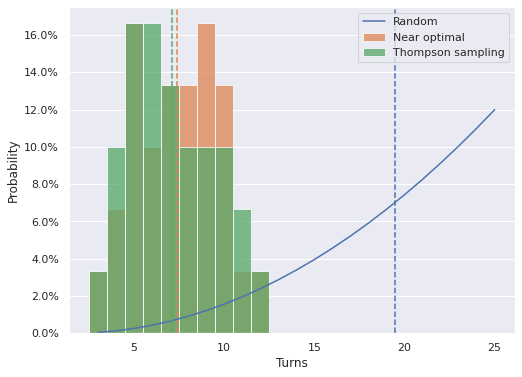

In [108]:
ax = plot_turn_dist(grid_turns_pmf_5_5_3,
                    color='C1', label="Near optimal",
                    mean=True, mean_kwargs={'c': 'C1'});
plot_turn_dist(random_5_5_3_pmf,
               kind='line', c='C0',
               mean=True, mean_kwargs={'c': 'C0'},
               label="Random",
               ax=ax)
plot_turn_dist(ts_turns_pmf_5_5_3,
               color='C2', label="Thompson sampling",
               mean=True, mean_kwargs={'c': 'C2'},
               ax=ax);

make_pct_yaxis(ax);

ax.legend(loc='upper right');

Note that while the turn distribution for Thompson sampling is concentrated further to the left, the expected numbers of turns for Thompson sampling and our near optimal strategy, indicated by the dashed vertical lines, are quite close.

No doubt we could improve the logic of our near optimal strategy to match (or perhaps even beat) Thompson sampling, but the generalization of Thompson sampling to the two-dimensional grid is so much more elegant that it seems hardly worthwhile.

### Standard battleship

Now that we understand these approaches to simplified versions of Battleship, we are ready to tackle the Thompson sampling approach to standard Battleship.

#### Random

From above we recall the turn distribution for random guessing at standard Battleship.

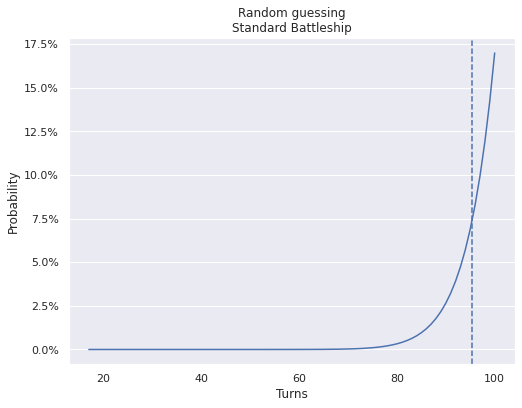

In [109]:
std_turn_ax.figure

#### Optimistic expected values

Generalizing the optimal one-dimensional strategy to two dimensions was sufficiently difficult that we do not attempt to define even a near optimal strategy for standard Battleship.  Configurations where several ships are adjacent, such as the one shown below, will certainly lead to complex and bug-prone branching logic.

In [110]:
ships = np.zeros((n_ships, GRID_LENGTH, GRID_LENGTH))
ships[0, 0, :5] = 1
ships[1, 1, :4] = 1
ships[2, 2, :3] = 1
ships[3, 3, :3] = 1
ships[4, 4, :2] = 1

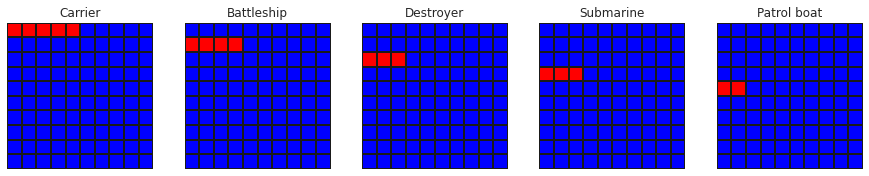

In [111]:
fig, axes = plt.subplots(ncols=n_ships, sharex=True, sharey=True,
                         figsize=(n_ships * 2.5, 2.5))

for (ship, name, ax) in zip(ships, SHIP_NAMES, axes):
    plot_board(ship, ax=ax);
    
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    ax.set_title(name);
    
fig.tight_layout();

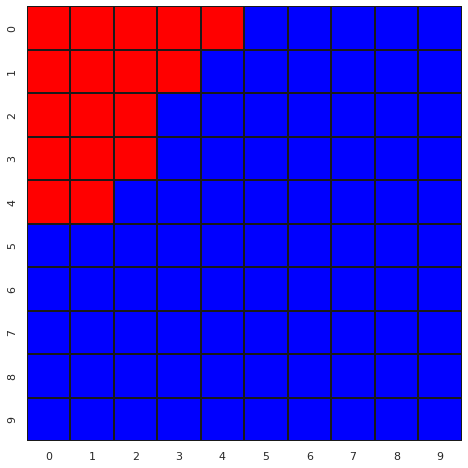

In [112]:
plot_board(to_board(ships));

In spite of these challenges, we will want to at least be able to benchmark the average number of turns Thompson sampling requires against other approaches.  Fortunately we can propose several scenarios for which the expected number of turns is straightforward to calculate.

### Extremely optimistic

We can make two assumptions to get a reasonable floor on the expected number of turns.

1. The first five hits we get are each from a different ship.
2. As soon as we hit a ship, we know the complete location of that ship.

Together with a search strategy for the first five hits, we can calculate the expected value in this unrealistic but instructive scenario.  Weakening these assumptions also leads to more realistic expected values to which we can compare the performance of Thompson sampling.

A fairly efficient search strategy for the first five hits in standard Battle ship is to search a mod-two grid (since the smallest ship has size two).

In [113]:
search_i, search_j = get_search_cells_2d((10, 10), 2)
search_grid = np.zeros((10, 10))
search_grid[search_i, search_j] = 1

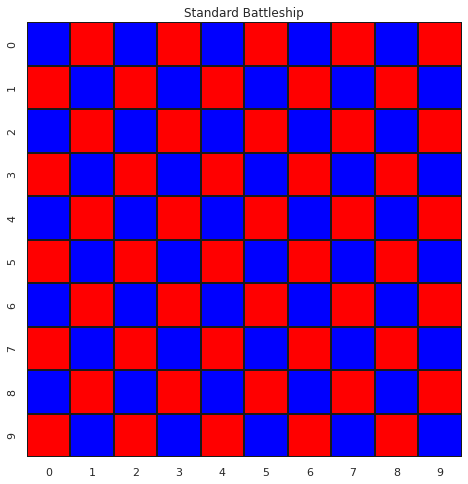

In [114]:
ax = plot_board(search_grid)
ax.set_title(r"Standard Battleship");

The distribution of the number of turns it takes to get five hits in these fifty cells is given below.

In [115]:
extreme_hit_pmf = get_random_guess_dist(search_grid.sum(),
                                        np.ceil(SHIP_SIZES / 2).sum(),
                                        n_hit=SHIP_SIZES.size)

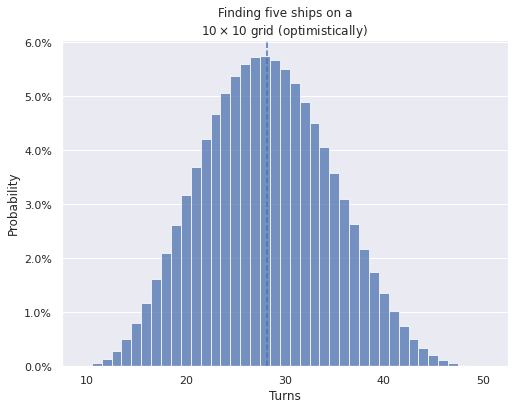

In [116]:
ax = plot_turn_dist(extreme_hit_pmf, mean=True)

make_pct_yaxis(ax);
ax.set_title("Finding five ships on a\n"
             r"$10 \times 10$ grid (optimistically)");

Under the second assumption, it will take us 12 more guesses to sink all the ships, so the expected number of turns to solve the game (optimistically) is

In [117]:
extreme_ev = extreme_hit_pmf.mean() + (SHIP_SIZES - 1).sum()

In [118]:
extreme_ev

40.18181818181814

Under the slightly more conservative (but still optimistic) assumption that it takes on average one and a half misses to determine the location and orientation of a ship, the expected value becomes

In [119]:
optim_ev = extreme_hit_pmf.mean() + 1.5 * SHIP_SIZES.size + (SHIP_SIZES - 2).sum()

In [120]:
optim_ev

42.68181818181814

We will use these two figures to benchmark the performance of Thompson sampling for standard Battleship in the next section.

#### Bayesian (Thompson sampling)

Generalizing the Thompson sampling strategy from one ship on a two-dimensional grid to standard Battleship is slighly more conceptually involved than generalize from one- to two-dimensional grids with one ship, but not too much more.

The generalization also requires some computational optimizations, as we can no longer expect to enumerate and store all possible configurations of the board on reasonably sized hardware.  To illustrate this and facilitate our eventual solution to this issue, we generate all possible configurations of each ship.

In [121]:
all_ships = [get_all_ships(GRID_LENGTH, ship_size) for ship_size in SHIP_SIZES]

Even though we can enumerate the possibilities for each ship easily,

In [122]:
n_ship_grids = np.array([len(ships) for ships in all_ships])

In [123]:
n_ship_grids

array([120, 140, 160, 160, 180])

there are more than $10^{10}$ possible combinations in the cartesian product of these configurations

In [124]:
np.log10(n_ship_grids).sum()

10.88882175214102

Now, not all elements of the Cartesian product produce valid boards (the ships may overlap).  An example of such an element is given below.

In [125]:
ships = np.zeros((n_ships, GRID_LENGTH, GRID_LENGTH))
ships[0, 0, :5] = 1
ships[1, 0, :4] = 1
ships[2, 0, :3] = 1
ships[3, 0, :3] = 1
ships[4, 0, :2] = 1

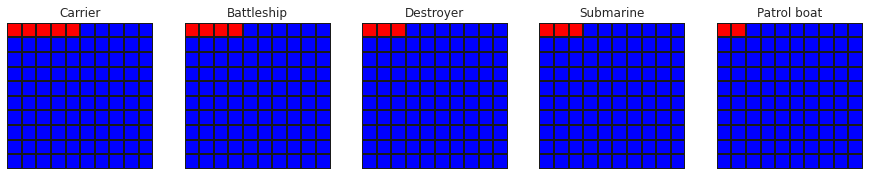

In [126]:
fig, axes = plt.subplots(ncols=n_ships, sharex=True, sharey=True,
                         figsize=(n_ships * 2.5, 2.5))

for (ship, name, ax) in zip(ships, SHIP_NAMES, axes):
    plot_board(ship, ax=ax);
    
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    ax.set_title(name);
    
fig.tight_layout();

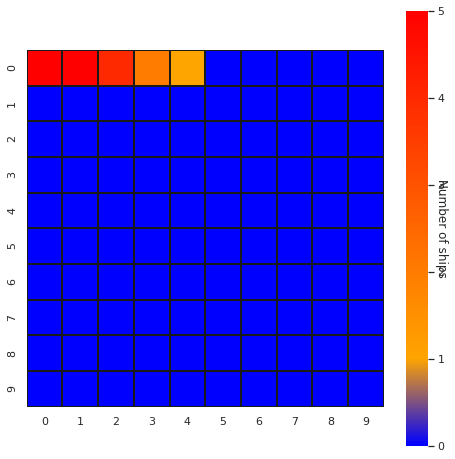

In [127]:
plot_board(to_board(ships), vmax=5.,
           cbar=True,
           cbar_kwargs={
               'format': '%d',
               'label': "Number of ships"
           });

The following function tests to see if an array of ship grids constitutes a valid board (has no overlap).

In [128]:
def has_no_overlap(ships, ship_axis=0, board_axis=(-2, -1)):
    return (to_board(ships, ship_axis=ship_axis)
                .max(axis=board_axis) \
                == 1)

In [129]:
has_no_overlap(ships)

False

Even eliminating sets of ships that do overlap, there are still too many possible boards to enumerate.  To address this challenge we will switch from Thompson _enumeration_, which is a more proper description of what we've been doing so far to Thompson _sampling_.  Instead of enumerating all boards compatible with the currently revealed information and choosing the unknown cell with the highest posterior probability of yielding a hit, we will draw a sample from the posterior distribution of compatible boards, calculate the cell most likely to yield a hit based on this sample to use as the next guess.

This sampling approach means we only need to be able to simulate random games of Battleship and check if they are compatible with the currently revealed information in order to generalize Thompson sampling to standard Battleship.  Simulating random games of Battleship is not particularly hard, but simulating games compatible with boards that have many spots revealed can take a prohibitively long time if done naively by sampling from each ship's possible configurations and then testing to see if the product of the samples is compatible.  (I have tried this and had it take over an hour to generate a compatible sample with approximately 30 cells revealed.)

Fortunately we can address this issue by intelligently propagating hits and misses from the aggregate board to each ship's grid and restricting to a subset of each ship's position that is more likely to produce a compatible board when combined with all the other ship samples.

Before walking through this process, we introduce the machinery necessary to sample random (compatible) boards.

In [130]:
def _sample_compat_ships_block(poss_ships, revealed,
                               rng=None, block_size=10_000):
    if rng is None:
        rng = np.random.default_rng()

    samples = np.stack([
            rng.choice(ships, size=block_size, shuffle=False)
                for ships in poss_ships
        ],
        axis=1
    )
    
    has_no_overlap_ = has_no_overlap(samples, ship_axis=1)
    valid_samples = samples[has_no_overlap_]
    
    if revealed.mask.all():
        return valid_samples
    else:
        is_compat_ = is_compat(to_board(valid_samples, ship_axis=1), revealed)
    
        return valid_samples[is_compat_]
    
def sample_compat_ships_block(poss_ships, revealed,
                              rng=None, block_size=10_000):
    block = []
    
    while len(block) == 0:
        block = _sample_compat_ships_block(
            poss_ships, revealed,
            rng=rng, block_size=block_size
        )
        
    return block


def generate_compat_ships(poss_ships, revealed,
                          rng=None, block_size=10_000):
    while True:
        yield from sample_compat_ships_block(
            poss_ships, revealed,
            rng=rng, block_size=block_size
        )

In [131]:
def take(n, gen, progress_bar=False):
    n_range = trange(n) if progress_bar else range(n)
    
    return [x for _, x in zip(n_range, gen)]

In [132]:
def sample_compat_ships(poss_ships, revealed, n,
                        rng=None, block_size=10_000,
                        progress_bar=False):
    compat_gen = generate_compat_ships(poss_ships, revealed,
                                       rng=rng)
    
    return np.array(take(n, compat_gen,
                         progress_bar=progress_bar))

def sample_ships(poss_ships, n,
                 rng=None, block_size=10_000,
                 progress_bar=False):
    empty = np.ma.masked_all_like(all_ships[0][0])
    
    return sample_compat_ships(poss_ships, empty, n,
                               rng=rng, block_size=block_size,
                               progress_bar=progress_bar)

We plot four randomly sampled boards below.

In [133]:
ships = sample_ships(all_ships, 4, rng=rng)

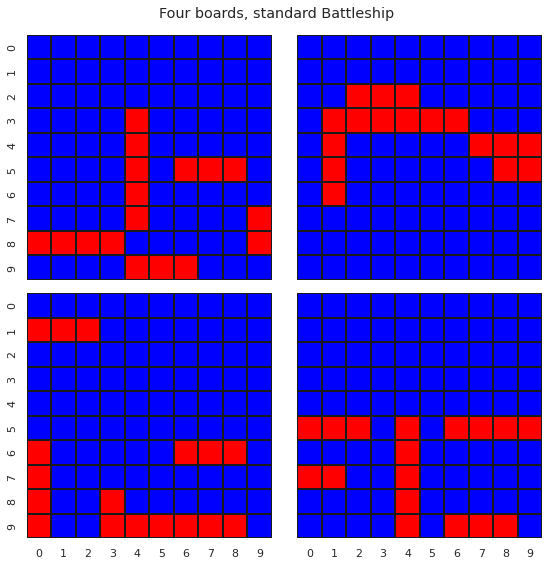

In [134]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(FIG_WIDTH, FIG_WIDTH))

for (ships_, ax) in zip(ships, axes.flat):
    plot_board(to_board(ships_), ax=ax);

fig.suptitle("Four boards, standard Battleship");
fig.tight_layout();

To illustrate how long it can take to sample compatible boards from the full Cartesian product, we randomly mask one third of the cells in the first board above and attempt to sample a compatible board.

In [135]:
masked_i, masked_j = rng.choice(
    np.indices((GRID_LENGTH, GRID_LENGTH)).reshape(2, -1),
    size=GRID_LENGTH**2 // 3, axis=1,
    replace=False, shuffle=False
)
mask = np.full((GRID_LENGTH, GRID_LENGTH), False)
mask[masked_i, masked_j] = True

revealed = np.ma.masked_array(to_board(ships[0]), mask=mask)

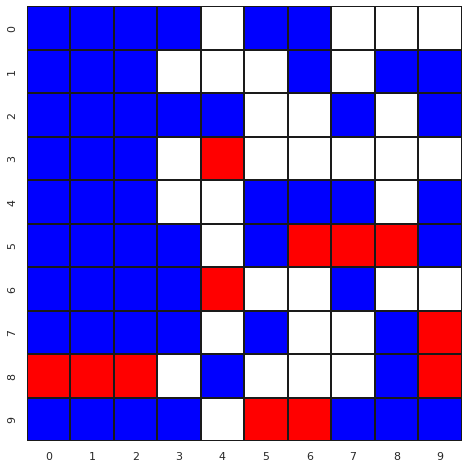

In [136]:
plot_board(revealed);

In [137]:
start = datetime.datetime.now()

try:
    sample_compat_ships(all_ships, revealed, 1, rng=rng)
except KeyboardInterrupt:
    end = datetime.datetime.now()
    
    print("You gave up trying to sample a compatible board"
          f"after {(end - start).total_seconds():.1f} seconds")

You gave up trying to sample a compatible boardafter 59.4 seconds


In order to implement the strategy for sampling compatible boards outlined above, we need to think about how to propagate hit/miss information about the combined board to each ship.  For a miss, this propagation is easy, as all ships must have been missed.  Propagating the information from a hit is much trickier, since in general we don't know which ship was hit.  We do however, know which ship was hit when our opponent announces that we sank one of their ships, because they have to tell us which one.

To implement Thompson sampling for standard Battleship then, we track not just what has been revealed, but what we can conclude has been revealed per ship.  We use this per-ship revealed information to reduce our possibilities the compatible ship grids _before_ sampling, then sample from the Cartesian product of these reduced sets, which produces compatible samples in at most seconds, even when many cells have been revealed.

Of course there are many situations where we can infer which ship has been hit. Consider the following board.

In [138]:
revealed = np.ma.masked_all((10, 10))
revealed[0, :2] = 0
revealed[1, 2] = 0
revealed[2, :2] = 0

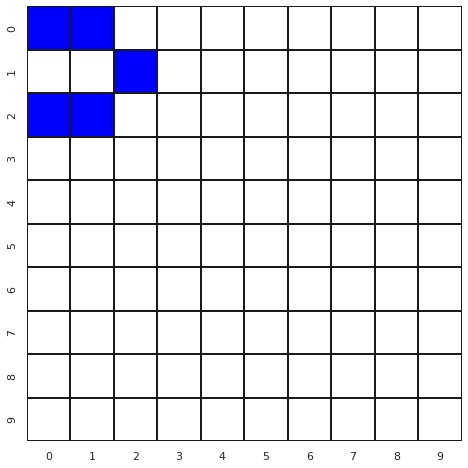

In [139]:
plot_board(revealed);

If guessing (1, 0) results in a hit, we can obviously conclude that the patrol boat was hit.  We do not account for situations such as this when propagating hit information from the combined board to individual ships to avoid cumbersome and error-prone conditional logic in our strategy.  (In fact, Thompson sampling accounts for this automatically without a special rule, as there will be only one possible position for the patrol boat compatible with this revealed information.)

We implement Thompson sampling for standard Battleship as described above.

In [140]:
class ThompsonStrategy(Strategy):
    def __init__(self, all_ships, rng=None, block_size=10_000):
        self._ship_strats = [
            SingleThompsonStrategy(ships) for ships in all_ships
        ]
        
        n_ship = len(all_ships)
        grid_shape = all_ships[0][0].shape
        self._ships_revealed = np.ma.masked_all((n_ship,) + grid_shape)

        self._rng = rng if rng is not None else np.random.default_rng()
        self._block_size = block_size
    
    def next_guess(self, revealed, n=None):
        post = np.ma.masked_array(
            self.sample_post(revealed, n=n),
            mask=~revealed.mask
        )
        
        return argmax_2d(post)
    
    def sample_post(self, revealed, n=None):
        all_compat_ships = [
            ship_strat.compat_ships(ship_revealed)
                for (ship_strat, ship_revealed)
                    in zip(self._ship_strats, self._ships_revealed)
        ]
        
        if n is None:
            compat_samples = sample_compat_ships_block(
                all_compat_ships, revealed,
                rng=self._rng, block_size=self._block_size
            )
        else:
            compat_samples = sample_compat_ships(
                all_compat_ships, revealed, n=n,
                rng=self._rng, block_size=self._block_size
            )
        
        return to_board(compat_samples, ship_axis=1).mean(axis=0)

    def reveal(self, i, j, hit_or_miss, sunk):
        if hit_or_miss == 0 or sunk is not None:
            self._ships_revealed[:, i, j] = 0
            
            if sunk is not None:
                self._ships_revealed[sunk, i, j] = 1

We use this strategy to play a game and visualize the results.

In [141]:
strat = ThompsonStrategy(all_ships, rng=rng)
game = play(ships[0], strat,
            progress_bar=True)

100%|██████████| 17/17 [00:02<00:00,  7.06it/s]


In [142]:
game.turns

46

In [143]:
%%capture
ani = animate_boards(game.turn_revealed)

In [144]:
HTML(ani.to_html5_video())

With a bit of extra bookeeping, we can also watch the posterior distribution used for Thompson sampling evolve after each turn.

In [145]:
game = Battleship(ships[0])
strat = ThompsonStrategy(all_ships, rng=rng)

posts = []

with tqdm(total=SHIP_SIZES.sum()) as pbar:
    while not game.is_solved:
        post = strat.sample_post(game.revealed, n=1_000)
        i, j = argmax_2d(np.ma.masked_array(
            post, mask=~game.revealed.mask
        ))

        hit_or_miss, sunk = game.guess(i, j)
        strat.reveal(i, j, hit_or_miss, sunk)
        
        posts.append(post)
        
        if hit_or_miss == 1:
            pbar.update()

100%|██████████| 17/17 [00:09<00:00,  1.83it/s]


In [146]:
%%capture
ani = animate_boards(posts, cbar=True)

In [147]:
HTML(ani.to_html5_video())

I'm not really sure how interpretable this is, but it is kind of mesmerizing.

Finally, we play 1,000 random games of standard Battleship using this strategy to understand the distributions of the number of turns required.

In [148]:
N_GAME = 1_000

In [149]:
def pickleable_play(args):
    i, ships = args

    return play(
        ships,
        ThompsonStrategy(all_ships,
                         rng=np.random.default_rng(SEED + i))
    )

with mp.Pool(mp.cpu_count()) as pool:
    ts_games = [game for game in tqdm(
        pool.imap_unordered(
            pickleable_play,
            zip(range(N_GAME),
                sample_ships(all_ships, N_GAME, rng=rng))
        ),
        total=N_GAME
    )]

100%|██████████| 1000/1000 [15:32<00:00,  1.07it/s]


In [150]:
ts_turns = np.array([game.turns for game in ts_games])
ts_turns_pmf = Pmf.from_seq(ts_turns)

In [151]:
ts_turns_pmf.to_csv('./ts_turns_pmf.csv')

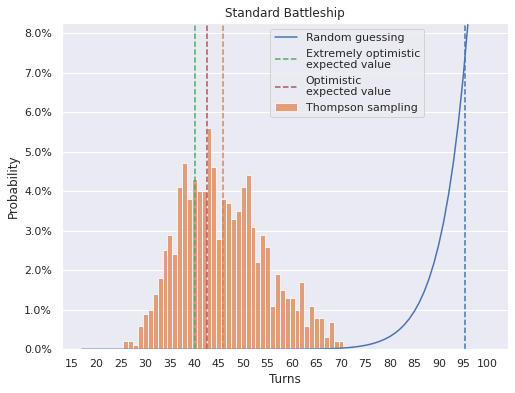

In [152]:
ax = plot_turn_dist(std_random_pmf, kind='line', mean=True,
                    label="Random guessing")
plot_turn_dist(ts_turns_pmf, color='C1',
               mean=True, mean_kwargs={'c': 'C1'},
               label="Thompson sampling", ax=ax);
ax.axvline(extreme_ev, c='C2', ls='--',
           label="Extremely optimistic\nexpected value");
ax.axvline(optim_ev, c='C3', ls='--',
           label="Optimistic\nexpected value");

ax.xaxis.set_major_locator(IndexLocator(base=5, offset=-2));

ax.set_ylim(0, 0.0825);
make_pct_yaxis(ax);

ax.legend(loc='upper right', bbox_to_anchor=(0.825, 1));
ax.set_title("Standard Battleship");

In [153]:
print(f"""
Extremely optimistic expected value = {extreme_ev:.2f}
Optimistic expected value = {optim_ev:.2f}
Thompson sampling expected value = {ts_turns_pmf.mean():.2f}
""")


Extremely optimistic expected value = 40.18
Optimistic expected value = 42.68
Thompson sampling expected value = 45.89



It's very exciting to see that Thompson sampling is not too much less efficient (on average) than our (extremely) optimistic baseline expected values!

For fun, we visualize the simulated games with the fewest and most turns, to see what it looks like when we get very lucky or unlucky.

In [154]:
min_ts_game = ts_games[(ts_turns == ts_turns.min()).argmax()]
max_ts_game = ts_games[(ts_turns == ts_turns.max()).argmax()]

In [155]:
%%capture
min_ani = animate_boards(min_ts_game.turn_revealed)
max_ani = animate_boards(max_ts_game.turn_revealed)

In [156]:
HTML(min_ani.to_html5_video())

In [157]:
HTML(max_ani.to_html5_video())

Interestingly, we see that the fastest game  three ships adjacent to each other. We likely got a bit of a speedup from finding two of those while attempting to sink the first one hit.

These simulated games naturally invite the question of whether Thompson sampling is optimal for standard Battleship (in the appropriate sense) as we have implemented it.  I strongly suspect that it is near-optimal, but not quite optimal.  Likely Thompson sampling combined with a few simple rules (like a restricted initial search grid) will produce slightly better (and perhaps even optimal) results.  Searching the internet for prior work on near optimal Battleship strategies yields a [few](https://slate.com/culture/2012/05/how-to-win-at-battleship.html) [articles](https://www.datagenetics.com/blog/december32011/) about strategies that take, on average, 42-44 guesses to complete the game.  Our simple Thompson sampling approach is quite close to that range, and with a few heuristics bolted on would likely be able to shave off a few turns to reach that level of performance.  We can also improve the performance of Thompson sampling at the cost of computational time by increasing the `block_size` used for sampling, resulting in a more accurate approximation to the posterior distribution.  Another interesting feature of the strategies in those articles is that they try to balance searching (exploration) and sinking known ships (exploitation) with rules, which we do not have to do explicitly when using Thompson sampling.

This framework is generalizable to [variations](https://en.wikipedia.org/wiki/Battleship_(game)#Variations) of Battleship such as salvo or or limited lying is allowed, and we may explore those generalizations in future posts.

Many thanks to [Kiril Zvezdarov](https://kirilzvezdarov.com/about.html) for providing helpful feedback on early drafts of this post.

This post is available as a Jupyter notebook [here](https://nbviewer.jupyter.org/gist/AustinRochford/6e21325d33b2be35cdf835f2ddaa9f3b).